In [41]:
#WINDOWS PATH
path_raw = '..\\..\\Dataset\\dataset\\images_sophie'
path_my = '..\\..\\Dataset\\dataset\\masks_sophie'
path_mask_cellpose = '..\\..\\Dataset\\dataset\\masks_resultat'


path_so = 'C:\\Users\\mezquitap\\Documents\\Dataset\\dataset\\masks_sophie'

#UNIX PATH
#path_raw = '../data/nucleus/images_manual' #image source
#path_my = '../data/nucleus/masks_manual' #mask source
#path_so = '/home/gumougeot/all/data/3d_nucleus/all_manual/masks_sophie'
path_njgift = '/home/gumougeot/all/data/OMERO_FSU/#3d NUCLEAR MORPHOLOGY - SEGMENTED/GIFT' #mask ai
path_njotsu = '/home/gumougeot/all/data/OMERO_FSU/#3d NUCLEAR MORPHOLOGY - SEGMENTED/OTSU'

In [23]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

napari-env


In [24]:
import os
import skimage as sk
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import erosion, dilation
from skimage.measure import find_contours
import numpy as np
import napari
import tifffile as tiff
import torchio as tio

In [25]:
def abs_path(root, listdir_):
    listdir = listdir_.copy()
    for i in range(len(listdir)):
        listdir[i] = root + '/' + listdir[i]
    return listdir

def abs_listdir(path):
    return abs_path(path, os.listdir(path))

def remove_begin(pattern, listdir_):
    listdir = listdir_.copy()
    for i in range(len(listdir)):
        listdir[i] = listdir[i][str.find(listdir[i],pattern):]
    return listdir

def plot3d(img_list, dpi=300):
    plt.figure(dpi=dpi)
    for i in range(len(img_list)):
        img = img_list[i]
        idx = len(img)//2
        plt.subplot(1,len(img_list),i+1)
        plt.imshow(img[idx])
    plt.show()

In [42]:
# start with sophie's
fname_so = os.listdir(path_so)

abs_so = abs_path(path_so, fname_so)
print("number of images ", len(abs_so))

# need to remove the beginning of the filenames
fname_so_no_begin = fname_so.copy()
abs_my = abs_path(path_my, fname_so_no_begin)
abs_raw = abs_path(path_raw, fname_so_no_begin)
abs_njgift = abs_path(path_njgift, fname_so_no_begin)
abs_njotsu = abs_path(path_njotsu, fname_so_no_begin)

abs_mask_cellpose = abs_path(path_mask_cellpose, fname_so_no_begin)

# the list below contains all the path in the following order:
# 1. sophie
# 2. mine
# 3. gift
# 4. otsu
# 5. the original image
#list_abs = [abs_so, abs_my, abs_njgift, abs_njotsu, abs_raw]


#1. original masks
#2. cellpose ai generated masks
#3. original images
list_abs = [abs_my, abs_mask_cellpose ,abs_raw]


number of images  93


In [43]:
imread(abs_my[0]).max()

255

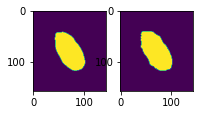

In [44]:
# plot the images
idx = 0
for i in range(len(list_abs)-1):
    path_img = list_abs[i][idx]
    img = imread(path_img)
    img = (img > 0).astype(int)
    img = img[len(img)//2]
    plt.subplot(1,4,i+1)
    plt.imshow(img)

In [29]:
# forms quadruplets

# list_abs_ = []
# for i in range(len(abs_so)):
#     list_abs_ += [[elmt[i] for elmt in list_abs]]
# print(len(list_abs_))
# list_abs_ = np.array(list_abs).T
# list_abs_.shape

In [30]:
# metric definition
def iou(inputs, targets, smooth=1):
    inter = (inputs & targets).sum()
    union = (inputs | targets).sum()
    return (inter+smooth)/(union+smooth)

def bce(inputs, targets, smooth=1e-7):
    y_pred = np.reshape(inputs, -1)
    y_true = np.reshape(targets, -1)
    y_pred = np.clip(y_pred, smooth, 1 - smooth)
    term_0 = (1-y_true) * np.log(1-y_pred + smooth)
    term_1 = y_true * np.log(y_pred + smooth)
    return -np.mean(term_0+term_1, axis=0)

In [31]:
def iou_border_erosion(inputs, targets, smooth=1):
    bor_in = erosion(inputs) ^ inputs
    bor_tg = erosion(targets) ^ targets
    return iou(bor_in, bor_tg)

def iou_border_dilation(inputs, targets, smooth=1):
    bor_in = dilation(inputs) ^ inputs
    bor_tg = dilation(targets) ^ targets
    return iou(bor_in, bor_tg)

def iou_in_and_border(inputs, targets, smooth=1):
    bor_in = erosion(inputs) ^ inputs
    bor_tg = erosion(targets) ^ targets
    all_in = np.stack([inputs, bor_in], axis=0)
    all_tg = np.stack([targets, bor_tg], axis=0)
    return iou(all_in,all_tg)

def iou_border_thick(inputs, targets, smooth=1):
    bor_in = erosion(inputs) ^ dilation(inputs)
    bor_tg = erosion(targets) ^ dilation(targets)
    return iou(bor_in, bor_tg)

In [32]:
# test
# m = np.array([[0,1,0.5],
#               [1,0,1],
#               [1,1,0]])
# print(iou(m,m))

# sophie vs mine on one image
# idx = 0
# path_vs = list_abs_[idx]
# img1 = imread(path_vs[0])
# img1 = (img1 > 0).astype(int)
# img2 = imread(path_vs[3])
# img2 = (img2 > 0).astype(int)
# print(iou(img1,img2,smooth=1))

# plot3d([img1,img2],dpi=100)

# intersection = (img1 & img2)
# bor_in = erosion(img1) ^ img1
# bor_tg = erosion(img2) ^ img2
# bor_in = erosion(img1) ^ dilation(img1)
# bor_tg = erosion(img2) ^ dilation(img2)
# bor_in = img1 ^ dilation(img1)
# bor_tg = img2 ^ dilation(img2)

# plot3d([bor_in,bor_tg])



In [33]:
# use find contour function? No version for 3D... 
# img1 = imread(path_vs[0])
# im = img1[len(img1)//2]

## with skimage
# contours = find_contours(im)
# print(contour[0].shape)

## with cv2
# im = np.stack([im,im,im],-1)
# plt.imshow(im)
# plt.show()
# imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# contour, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(contour[0].shape)

## plot contours
# def contour_to_img(contour, shape):
#     out = np.zeros(shape)
#     for i in range(len(contour)):
#         x = contour[i][0][0]
#         y = contour[i][0][1]
#         out[y][x] = 1
#     return out
# plt.figure(dpi=200)
# out = contour_to_img(contour[0], im.shape)
# plt.imshow(out)

In [48]:
def versus(fct, list_abs1,list_abs2):
    """
    Computes the function 'fct' over the whole list_abs1 and list_abs2
    """
    mean = 0
    count = 0
    for i in range(len(list_abs1)):
        if os.path.exists(list_abs1[i]) and os.path.exists(list_abs2[i]):
            
            img1 = imread(list_abs1[i])
            img1 = (img1 > 0).astype(int)
            img2 = imread(list_abs2[i])
            img2 = (img2 > 0).astype(int)
            if sum(img1.shape)!=sum(img2.shape):
                print("bug:", list_abs1[i])
                pass
            else:
                mean += fct(img1,img2)
                count += 1
    return mean / count

def versus_one(fct, in_path, tg_path):
    img1 = imread(in_path)
    img1 = (img1 > 0).astype(int)
    img2 = imread(tg_path)
    img2 = (img2 > 0).astype(int)
    if sum(img1.shape)!=sum(img2.shape):
        print("bug:", list_abs[i])
        return
    return fct(img1, img2)

def versus_all(versus, fct, list_abs):
    """
    use the "versus" function to apply the "fct" function over the 
    different elements in list "list_abs" of length 4.
    """
    print("sophie vs mine", versus(fct, list_abs[0], list_abs[1]))
    print("sophie vs gift", versus(fct, list_abs[0], list_abs[2]))
    print("sophie vs otsu", versus(fct, list_abs[0], list_abs[3]))

    print("mine vs gift", versus(fct, list_abs[1], list_abs[2]))
    print("mine vs otsu", versus(fct, list_abs[1], list_abs[3]))

    print("otsu vs gift", versus(fct, list_abs[2], list_abs[3]))

In [49]:
versus_all(versus_one, iou, np.transpose(list_abs)[0])

sophie vs mine 0.8363969855257387
sophie vs gift 0.02944933538071282


IndexError: index 3 is out of bounds for axis 0 with size 3

In [50]:
print(versus(iou, list_abs[0], list_abs[1]))

0.717184576157508
current idx:  24
image name:  KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_R1_18_C0.tif
sophie vs mine 0.7617334423548651
sophie vs gift 0.017910594486546572
current idx:  25
image name:  KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_R1_23_C0.tif
sophie vs mine 0.8521214459860031
sophie vs gift 0.03672323350466615
current idx:  25
image name:  KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_R1_23_C0.tif
sophie vs mine 0.8521214459860031
sophie vs gift 0.03672323350466615


In [36]:
# fct = iou_border_thick
fct = iou
print("sophie vs mine", versus(fct, list_abs[0], list_abs[1]))
print("sophie vs gift", versus(fct, list_abs[0], list_abs[2]))
print("sophie vs otsu", versus(fct, list_abs[0], list_abs[3]))

print("mine vs gift", versus(fct, list_abs[1], list_abs[2]))
print("mine vs otsu", versus(fct, list_abs[1], list_abs[3]))

print("otsu vs gift", versus(fct, list_abs[2], list_abs[3]))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mezquitap\\Documents\\Dataset\\dataset\\masks_resultat\\KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_M2_7_C0.tif'

In [ ]:
# temporary: store the file in folders

# from shutil import copyfile
# out_so = '/home/gumougeot/all/data/3d_nucleus/all_manual/eval_metrics/sophie/'
# out_gu = '/home/gumougeot/all/data/3d_nucleus/all_manual/eval_metrics/guillaume/'
# out_gi = '/home/gumougeot/all/data/3d_nucleus/all_manual/eval_metrics/gift/'
# out_ot = '/home/gumougeot/all/data/3d_nucleus/all_manual/eval_metrics/otsu/'
# list_out = [out_so, out_gu, out_gi, out_ot]

# # remove bugs
# bugs = ['/mnt/52547A99547A8011/data/raw mal seg/2018051_1527145113.736_Ath_Col0--KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_U1_7_C0.tif']
# bugs_idx = []
# # get bug indexs
# for i in range(len(list_out)):
#     for j in range(len(list_abs[i])):
#         if list_abs[i][j] in bugs:
#             bugs_idx += [j]

# # copy files to the folder 
# for i in range(len(list_out)):
#     for j in range(len(list_abs[i])):
        
#         if j not in bugs_idx:
#             fname = fname_so_no_begin[j]
# #             os.remove(list_out[i]+fname)
#             copyfile(list_abs[i][j], list_out[i]+fname)

## visualization

visualize the segmentations results with napari
it has been made interactive with the following keybindings:

'n' for next image

'b' for previous image

'p' to display properties

In [38]:
# tiff utils
def tif_read_meta(tif_path, display=False):
    """
    read the metadata of a tif file and stores them in a python dict.
    if there is a 'ImageDescription' tag, it transforms it as a dictionary
    """
    meta = {}
    with tiff.TiffFile(tif_path) as tif:
        for page in tif.pages:
            for tag in page.tags:
                tag_name, tag_value = tag.name, tag.value
                if display: print(tag.name, tag.code, tag.dtype, tag.count, tag.value)

                # below; fix storage problem for ImageDescription tag
                if tag_name == 'ImageDescription': 
                    list_desc = tag_value.split('\n')
                    dict_desc = {}
                    for idx, elm in enumerate(list_desc):
                        split = elm.split('=')
                        dict_desc[split[0]] = split[1]
                    meta[tag_name] = dict_desc
                else:
                    meta[tag_name] = tag_value
            break # just check the first image
    return meta

def tif_get_spacing(path):
    """
    get the image spacing stored in the metadata file.
    """
    img_meta = tif_read_meta(path)

    xres = (img_meta["XResolution"][1]/img_meta["XResolution"][0])*1e-6
    yres = (img_meta["YResolution"][1]/img_meta["YResolution"][0])*1e-6
    zres = float(img_meta["ImageDescription"]["spacing"])*1e-6
    max_dim = min([xres,yres,zres])
    xres = max_dim / xres
    yres = max_dim / yres
    zres = max_dim / zres
    return (xres, yres, zres)

def load_resample_img(path, spacing):
    """
    load and resample the image 
    """
    transform = tio.Resample(spacing)
    img = imread(path)
    timg = np.expand_dims(img, 0)
    return transform(timg)[0]

In [39]:
idx = 0

#name_dict = {
#    'image'    :-1,
#    'sophie'   :0,
#    'guillaume':1,
#    'gift'     :2,
#    'otsu'     :3,
#}

name_dict = {
    'image'    :-1,
    'original mask'   :0,
    'cellpose mask': 1,
}


fct = iou # metric to display
spacing = tif_get_spacing(list_abs[-1][idx])
spacing = np.flip(spacing) # CAREFUL: spacing must be in ZYX and not in XYZ!

viewer = napari.Viewer()

for k,v in name_dict.items():
    if k=='image':
        
        viewer.add_image(load_resample_img(list_abs[v][idx], spacing), name=k)
    else: # change color properties
        viewer.add_labels(load_resample_img(list_abs[v][idx], spacing)//255 * (1+v), name=k)

def replace_layers(viewer):
    global idx
    for k, v in name_dict.items():
        if k=='image':
            viewer.layers[k].data = load_resample_img(list_abs[v][idx], spacing)
        else: # change color properties
            viewer.layers[k].data = load_resample_img(list_abs[v][idx], spacing)//255 * (1+v)
    return viewer
    
@viewer.bind_key('n', overwrite=True)
def napari_print_next(viewer):
    global idx
    if idx < len(list_abs[0])-1:
        idx += 1
        viewer = replace_layers(viewer)

@viewer.bind_key('b', overwrite=True)
def napari_print_previous(viewer):
    global idx
    if idx > 0:
        idx -= 1
        viewer = replace_layers(viewer)
        
@viewer.bind_key('p', overwrite=True)
def napari_print_properties(viewer):
    global idx
    print("current idx: ", idx)
    print("image name: ", list_abs[v][idx].split('/')[-1])
    versus_all(versus_one, fct, np.transpose(list_abs)[idx])
    


current idx:  4
image name:  KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_M2_7_C0.tif
